# Time Series Cross Validation

In [1]:
import pandas as pd
import numpy as np

#we include some parallel CPU examples to speed up your CV!
#if you don't have joblib installed then uncomment the line below.
#!pip install joblib
from joblib import Parallel, delayed

#suppress ARIMA warnings
import warnings
warnings.filterwarnings('ignore')

Up till now we have used a single validation period to select our best model.  The weakness of that approach is that it gives you a sample size of 1 (that's better than nothing, but generally poor statistics!).  Time series cross validation is an approach to provide more data points when comparing models. In the classicial time series literature time series cross validation is called a **Rolling Forecast Origin**.  There may also be benefit of taking a **sliding window** approach to cross validaiton.  This second approach maintains a fixed sized training set.  I.e. it drops older values from the time series during validation.

## Rolling Forecast Origin

The following code and output provide a simplified view of how rolling forecast horizons work in practice.

In [2]:
def rolling_forecast_origin(train, min_train_size, horizon):
    '''
    Rolling forecast origin generator.
    '''
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val

In [3]:
full_series = [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222, 1234, 3456]

test = full_series[-2:]
train = full_series[:-2]
print('full training set: {0}'.format(train))
print('hidden test set: {0}'.format(test))

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]
hidden test set: [1234, 3456]


In [4]:
cv_rolling = rolling_forecast_origin(train, min_train_size=4, horizon=2)
cv_rolling

<generator object rolling_forecast_origin at 0x7f229e5d5f48>

In [5]:
i = 0
for cv_train, cv_val in cv_rolling:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708, 1900]
-----
CV[2]
Train:	[2502, 2414, 2800, 2143, 2708]
Val:	[1900, 2333]
-----
CV[3]
Train:	[2502, 2414, 2800, 2143, 2708, 1900]
Val:	[2333, 2222]
-----


## Sliding Window Cross Validation

In [6]:
def sliding_window(train, window_size, horizon, step=1):
    '''
    sliding window  generator.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int
        lookback - how much data to include.
    
    horizon: int
        forecast horizon
        
    step: int, optional (default=1)
        step=1 means that a single additional data point is added to the time
        series.  increase step to run less splits.
        
    Returns:
        array-like, array-like
    
        split_training, split_validation
    '''
    for i in range(0, len(train) - window_size - horizon + 1, step):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size:window_size+i+horizon]
        yield split_train, split_val

This code tests its with `step=1`

In [7]:
cv_sliding = sliding_window(train, window_size=4, horizon=1)

print('full training set: {0}\n'.format(train))

i = 0
for cv_train, cv_val in cv_sliding:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708]
-----
CV[2]
Train:	[2414, 2800, 2143, 2708]
Val:	[1900]
-----
CV[3]
Train:	[2800, 2143, 2708, 1900]
Val:	[2333]
-----
CV[4]
Train:	[2143, 2708, 1900, 2333]
Val:	[2222]
-----


The following code tests it with `step=2`.  Note that you get less splits.  The code is less computationally expensive at the cost of less data.  That is probably okay.

In [8]:
cv_sliding = sliding_window(train, window_size=4, horizon=1, step=2)

print('full training set: {0}\n'.format(train))

i = 0
for cv_train, cv_val in cv_sliding:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708]
-----
CV[2]
Train:	[2800, 2143, 2708, 1900]
Val:	[2333]
-----


# Parallel Cross Validation Example using Naive1

In [9]:
from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.datasets import load_emergency_dept
from sklearn.metrics import mean_absolute_error

In [10]:
train = load_emergency_dept()

In [11]:
def forecast_accuracy(model, train, test, metric):
    '''
    Returns forecast accuracy of model fit on 
    training data and compared against a test set 
    with a given metric.
    
    Parameters:
    ----------
    model - object
        forecasting model with .fit(train) and
        .predict(horizon) methods
        
    train - array-like
        training data
        
    test: array-like
        holdout data for testing
        
    metric: function
        error measure sig (y_true, y_preds)
    '''
    model.fit(train)
    preds = model.predict(len(test))
    return metric(y_true=test, y_pred=preds)

In [12]:
def cross_validation_score(model, train, cv, metric, n_jobs=-1):
    '''
    Calculate cross validation scores
    
    Parameters:
    ----------
    model: object
        forecast model
    
    train: array-like
        training data
        
    metric: func(y_true, y_pred)
        forecast error metric
    
    n_jobs: int, optional (default=-1)
        when -1 runs across all cores
        set = 1 to run each cross validation seperately.
        using -1 speeds up cross validation of slow running models.    
    '''
    cv_scores = Parallel(n_jobs=n_jobs)(delayed(forecast_accuracy)(model, 
                                                cv_train, 
                                                cv_test, 
                                                mean_absolute_error) 
                              for cv_train, cv_test in cv)

    return np.array(cv_scores)
    

In [13]:
model = Naive1()

In [14]:
#%%timeit runs the code multiple times to get an estimate of runtime.
#comment if out to run the code only once.

Run on a single core

In [15]:
#%%timeit
cv = sliding_window(train, window_size=14, horizon=7, step=1)
results_1 = cross_validation_score(model, train, cv, mean_absolute_error, 
                                   n_jobs=1)

Run across multiple cores by setting `n_jobs=-1`

In [16]:
#%%timeit #should see a little bit of speed up, but not loads with basic model.
cv = sliding_window(train, window_size=14, horizon=7, step=1)
results_2 = cross_validation_score(model, train, cv, mean_absolute_error,
                                       n_jobs=-1)

In [17]:
results_1.shape

(324,)

In [18]:
results_2.shape

(324,)

In [19]:
print(results_1.mean(), results_1.std())

26.653439153439148 10.346957901088238


just to illustrate that the results are the same - the difference is runtime.

In [20]:
print(results_2.mean(), results_2.std())

26.653439153439148 10.346957901088238


## Cross validation example using ARIMA - does it speed up when CV run in Parallel?

In [19]:
#use ARIMA from pmdarima as that has a similar interface to baseline models.
from pmdarima import ARIMA, auto_arima

In [20]:
#ato_model = auto_arima(train, suppress_warnings=True, n_jobs=-1, m=7)

In [21]:
#auto_model

In [22]:
#create arima model - reasonably complex model
#order=(1, 1, 2), seasonal_order=(2, 0, 2, 7)
args = {'order':(1, 1, 2), 'seasonal_order':(2, 0, 2, 7)}
model = ARIMA(order=args['order'], seasonal_order=args['seasonal_order'],
              enforce_stationarity=False, suppress_warnings=True)

In [25]:
%%time
cv = rolling_forecast_origin(train, min_train_size=320, horizon=7)
results_1 = cross_validation_score(model, train, cv, mean_absolute_error, 
                                   n_jobs=1)

CPU times: user 37.6 s, sys: 324 ms, total: 37.9 s
Wall time: 12.2 s


comment out %%timeit to run the code only once!

you should see a big improvement in performance.  mine went 
from 12.3 seconds to 2.4 seconds.

In [26]:
%%time
cv = rolling_forecast_origin(train, min_train_size=320, horizon=7)
results_2 = cross_validation_score(model, train, cv, mean_absolute_error, 
                                   n_jobs=-1)

CPU times: user 1.78 s, sys: 196 ms, total: 1.97 s
Wall time: 3 s


In [27]:
results_1.shape

(18,)

In [28]:
results_2.shape

(18,)

In [29]:
results_1.mean()

15.58663509219668

In [30]:
results_2.mean()

15.586662939018318

# Cross Validation with multiple forecast horizons

In [49]:
def rolling_forecast_origin(train, min_train_size, horizons, step=1):
    '''
    Rolling forecast origin generator.

    Parameters:
    --------
    train: array-like
        training data for time series method
    
    min_train_size: int
        lookback - initial training size
    
    horizons: list
        forecast horizon list e.g. [7, 14, 28]
        
    step: int, optional (default=1)
        step=1 means that a single additional data point is added to the time
        series.  increase step to run less splits.
        
    Returns:
        array-like, array-like
    
        split_training, split_validation, horizons
    '''
    horizon = max(horizons)
    for i in range(0, len(train) - min_train_size - horizon + 1, step):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val, horizons

In [27]:
def sliding_window(train, window_size, horizons, step=1):
    '''
    sliding window  generator.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int
        lookback - how much data to include.
    
    horizons: list
        forecast horizon
        
    step: int, optional (default=1)
        step=1 means that a single additional data point is added to the time
        series.  increase step to run less splits.
        
    Returns:
        array-like, array-like
    
        split_training, split_validation, horizons
    '''
    horizon = max(horizons)
    for i in range(0, len(train) - window_size - horizon + 1, step):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size:window_size+i+horizon]
        yield split_train, split_val, horizons

In [24]:
def forecast_accuracy(model, train, test, horizons, metric):
    '''
    Returns forecast accuracy of model fit on 
    training data and compared against a test set 
    with a given metric.  
    
    Allows multiple forecast horizons.  The model predicts
    the maximum forecast horizon and then calculates the 
    accuracy across each.
    
    Parameters:
    ----------
    model - object
        forecasting model with .fit(train) and
        .predict(horizon) methods
        
    train - array-like
        training data
        
    test: array-like
        holdout data for testing
        
    horizons: list
        list of forecast horizons e.g. [7, 14, 28]
        
    metric: function
        error measure sig (y_true, y_preds)
    '''
    h_accuracy = []
    model.fit(train)
    preds = model.predict(max(horizons))
    for horizon in horizons:
        score = metric(y_true=test[:horizon], y_pred=preds[:horizon])
        h_accuracy.append(score)
    return h_accuracy

In [35]:
def cross_validation_score(model, train, cv, metric, n_jobs=-1):
    '''
    Calculate cross validation scores
    
    Parameters:
    ----------
    model: object
        forecast model
    
    train: array-like
        training data
        
    metric: func(y_true, y_pred)
        forecast error metric
    
    n_jobs: int, optional (default=-1)
        when -1 runs across all cores
        set = 1 to run each cross validation seperately.
        using -1 speeds up cross validation of slow running models.   
        
        
    Returns array of arrays
    '''
    cv_scores = Parallel(n_jobs=n_jobs)(delayed(forecast_accuracy)(model, 
                                                cv_train, 
                                                cv_test, 
                                                horizons,
                                                metric) 
                              for cv_train, cv_test, horizons in cv)

    return np.array(cv_scores)

In [45]:
cv = sliding_window(train, window_size=200, horizons=[7,14,28], step=1)
results_h = cross_validation_score(model, train, cv, mean_absolute_error,
                                   n_jobs=-1)

In [46]:
#results_h is a np array where each row is a list with 3 items
#col 1 = 7 days
#col 2 = 14 days
#col 3 = 28 days
results_h

array([[19.93865461, 21.68843935, 18.05717216],
       [18.01282369, 19.10355357, 17.01336677],
       [17.50760868, 17.50028055, 14.97335363],
       [18.4961093 , 18.48323659, 15.48827774],
       [19.15062451, 19.81726671, 15.89797954],
       [20.60009427, 20.23717011, 15.52364669],
       [16.80658008, 17.46524181, 14.55256391],
       [19.2362758 , 17.0807867 , 14.4892809 ],
       [17.33995865, 17.05248708, 14.46793961],
       [17.84152246, 15.86702798, 14.19316717],
       [17.61010053, 16.08568063, 13.98431784],
       [20.53320462, 16.0470176 , 14.43120564],
       [19.6096856 , 14.4598838 , 13.78238015],
       [17.91103039, 13.73261928, 13.18386062],
       [15.20299779, 13.28060278, 13.59281897],
       [15.92575473, 14.2503689 , 12.94632197],
       [13.23770789, 12.89871615, 12.0077787 ],
       [14.9285796 , 12.58179635, 12.16504052],
       [11.68575324, 12.48536852, 11.42394031],
       [10.31691556, 13.14311339, 11.1181957 ],
       [10.99766109, 14.10459357, 11.303

In [47]:
#it is easier to manage this as a dataframe
df = pd.DataFrame(results_h, columns=['7days', '14days', '28days'])
df.head()

,7days,14days,28days
0,19.938655,21.688439,18.057172
1,18.012824,19.103554,17.013367
2,17.507609,17.500281,14.973354
3,18.496109,18.483237,15.488278
4,19.150625,19.817267,15.897980


In [48]:
#ten call the describe function to get results
#also you can save the raw results (recommended!)
df.describe()

,7days,14days,28days
count,117.000000,117.000000,117.000000
mean,14.412050,14.336333,13.991379
std,3.011346,2.022619,1.235327
min,7.365878,8.660373,11.118196
25%,12.102072,12.978478,13.128872
50%,13.976272,14.250369,13.950694
75%,16.890996,15.470797,14.912828
max,21.947033,21.688439,18.057172


In [50]:
cv = rolling_forecast_origin(train, min_train_size=200, horizons=[7,14,28], 
                             step=1)
results_h = cross_validation_score(model, train, cv, mean_absolute_error,
                                   n_jobs=-1)

In [52]:
df = pd.DataFrame(results_h, columns=['7days', '14days', '28days'])
df.describe()

,7days,14days,28days
count,117.000000,117.000000,117.000000
mean,14.211314,14.080860,13.793406
std,2.907189,2.006614,1.161488
min,9.266781,10.261205,10.957218
25%,11.840689,12.542844,13.030809
50%,13.996789,13.991023,13.809597
75%,15.895423,15.043143,14.437080
max,21.930518,21.688439,18.057172


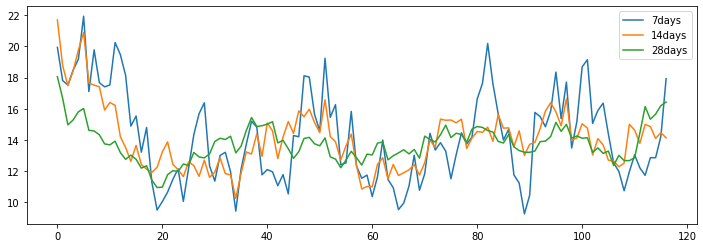

In [53]:
df.plot(figsize=(12,4))